# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

*Откроем файл с данными и изучим общую информацию.*

In [ ]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict,
    train_test_split
)

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format) #вывод значения float до 2 знаков после запятой

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


*Загрузам данные и выведем первые 10 строчек датафрейма на экран.*

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [ ]:
# с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


*Посмотрим на соотношение классов.*

In [ ]:
display(data['toxic'].value_counts())

0    143106
1     16186
Name: toxic, dtype: int64

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))

#sns.countplot(data=data, x='toxic',  ax=ax)
#ax.axes.get_xaxis().set_visible(False)
#plt.title("Соотношение классов")
#plt.show()

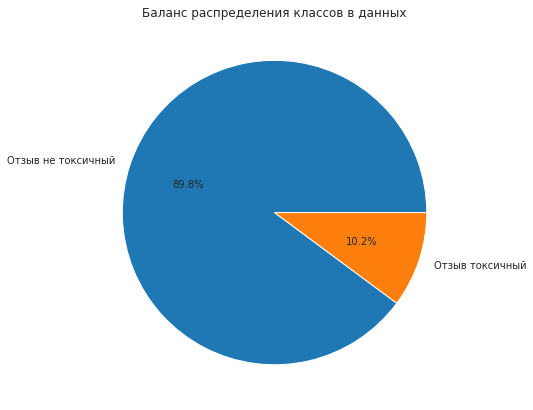

In [ ]:
sns.set_style('darkgrid')
data['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[7,7],
                                                legend=False, autopct='%1.1f%%',
                                                labels=['Отзыв не токсичный',
                                                        'Отзыв токсичный'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

*Наблюдается дисбаланс классов.*


*Напишем функции для очистки текстов от лишних символов, приведению к нижнему регистру и лемматизации.*

In [ ]:
def clear_text(text):
    re_list = re.sub(r"(?:\n|\r)", " ", text)
    re_list = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    re_list = re_list.split()
    re_list = " ".join(re_list)
    re_list = re_list.lower()
    return re_list

m = WordNetLemmatizer()

def lemmatize_text(text):
    word_list = nltk.word_tokenize(text)

    return ' '.join([m.lemmatize(w) for w in word_list])

data['text'] = data['text'].apply(clear_text)
data['lemm_text'] = data['text'].apply(lemmatize_text)

# проверим
data.head()

,text,toxic,lemm_text
0,explanationwhy the edits made under my usernam...,0,explanationwhy the edits made under my usernam...
1,daww he matches this background colour im seem...,0,daww he match this background colour im seemin...
2,hey man im really not trying to edit war its j...,0,hey man im really not trying to edit war it ju...
3,morei cant make any real suggestions on improv...,0,morei cant make any real suggestion on improve...
4,you sir are my hero any chance you remember wh...,0,you sir are my hero any chance you remember wh...


In [ ]:
# удалим столбец 'text'
data = data.drop('text', axis = 1)

## Обучение

*Разделим данные на обучающую и тестовые выборки.*

In [ ]:
features = data.drop('toxic', axis=1)
target = data['toxic'].values

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            stratify=target,
                                                                            random_state=12345)

In [ ]:
features_test.shape

(31859, 1)

In [ ]:
features_train.shape

(127433, 1)

In [ ]:
stopwords = set(nltk_stopwords.words('english'))
stopwords = list(stopwords)

In [ ]:
# создадим корпус из лемматизированных и очищенных слов
corpus_lemm_train = features_train['lemm_text'].values
corpus_lemm_train.shape

(127433,)

In [ ]:
# считаем величину TF-IDF для обучающей выборки

count_tf_idf_train = TfidfVectorizer(stop_words = stopwords)
features_train = count_tf_idf_train.fit_transform(corpus_lemm_train)
display(features_train.shape)

(127433, 223623)

In [ ]:
# создадим так же корпус слов и для тестовой выборки
corpus_lemm_test = features_test['lemm_text'].values
corpus_lemm_test.shape

(31859,)

In [ ]:
# считаем величину TF-IDF для обучающей выборки

count_tf_idf_test = TfidfVectorizer(stop_words = stopwords)
features_test = count_tf_idf_train.transform(corpus_lemm_test)
display(features_test.shape)

(31859, 223623)

*Проведем обучение моделей LogisticRegression, DecisionTreeClassifier,  и LGBMClassifier.*

### LogisticRegression

*Подберем наилучшие параметры для LogisticRegression.*

In [ ]:
%%time

pipe_lr = Pipeline([('model', LogisticRegression(random_state=12345, solver='sag', class_weight='balanced'))])

parametrs_lr = {'model__C': range (1, 10),
                'model__max_iter': range (10,17,2)}
grid_lr = GridSearchCV(pipe_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(features_train, target_train)
params_lr = grid_lr.best_params_
f1_lr = grid_lr.best_score_
print('Наилучшие параметры для LogisticRegression:', params_lr)
print('F1 LogisticRegression на обучающей выборке:', f1_lr)

best_rf = grid_lr.best_estimator_

best_rf.fit(features_train, target_train)

Наилучшие параметры для LogisticRegression: {'model__C': 9, 'model__max_iter': 16}
F1 LogisticRegression на обучающей выборке: 0.7584248366410239
CPU times: user 1min 59s, sys: 177 ms, total: 1min 59s
Wall time: 1min 59s


Pipeline(steps=[('model',
                 LogisticRegression(C=9, class_weight='balanced', max_iter=16,
                                    random_state=12345, solver='sag'))])

### DecisionTreeClassifier

*Подберем наилучшие параметры для DecisionTreeClassifier.*

In [ ]:
%%time

pipe_dtc = Pipeline([('model', DecisionTreeClassifier(random_state=12345, class_weight='balanced'))])
#clf_dtc = DecisionTreeClassifier(random_state = 12345, class_weight='balanced')
params_dtc = {
   'model__criterion':['gini', 'entropy'],
   'model__max_depth':list(range(1,15,5)),
}
grid_dtc = GridSearchCV(pipe_dtc, params_dtc, cv=3, scoring='f1', verbose=5)
grid_dtc.fit(features_train, target_train)
params_dtc = grid_dtc.best_params_
f1_dtc = grid_dtc.best_score_.round(2)
print('Наилучшие параметры для DecisionTreeClassifier:', params_dtc)
print('F1 DecisionTreeClassifier на обучающей выборке:', f1_dtc)

best_dtc = grid_dtc.best_estimator_

best_dtc.fit(features_train, target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ......model__criterion=gini, model__max_depth=1; total time=   9.0s
[CV 2/3] END ......model__criterion=gini, model__max_depth=1; total time=   9.1s
[CV 3/3] END ......model__criterion=gini, model__max_depth=1; total time=   8.9s
[CV 1/3] END ......model__criterion=gini, model__max_depth=6; total time=  10.9s
[CV 2/3] END ......model__criterion=gini, model__max_depth=6; total time=  10.7s
[CV 3/3] END ......model__criterion=gini, model__max_depth=6; total time=  10.5s
[CV 1/3] END .....model__criterion=gini, model__max_depth=11; total time=  13.5s
[CV 2/3] END .....model__criterion=gini, model__max_depth=11; total time=  14.0s
[CV 3/3] END .....model__criterion=gini, model__max_depth=11; total time=  13.4s
[CV 1/3] END ...model__criterion=entropy, model__max_depth=1; total time=   9.2s
[CV 2/3] END ...model__criterion=entropy, model__max_depth=1; total time=   9.4s
[CV 3/3] END ...model__criterion=entropy, model__

Pipeline(steps=[('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=11,
                                        random_state=12345))])

### RandomForestClassifier

*Подберем наилучшие параметры для RandomForestClassifier.*

In [ ]:
%%time

pipe_rfc = Pipeline([('model', RandomForestClassifier(n_estimators=100, random_state=12345, class_weight='balanced'))])
#clf_rfc = RandomForestClassifier(n_estimators=100, random_state=12345, class_weight='balanced')
params_rfc = {'model__max_depth': [3, 7, 11, 15, 10, 20],
              'model__min_samples_leaf': [1, 2, 4, 8],
              'model__min_samples_split': [2, 5, 10]}

grid_rfc = RandomizedSearchCV(pipe_rfc,
                        params_rfc,
                        n_iter = 2,
                        scoring = 'f1',
                        n_jobs = -1,
                        verbose = 5,
                        random_state = 12345)
grid_rfc.fit(features_train, target_train)
params_rfc = grid_rfc.best_params_
f1_rfc = grid_rfc.best_score_
print('Наилучшие параметры для RandomForestClassifier:', params_rfc)
print('F1 RandomForestClassifier на обучающей выборке:', f1_rfc)

best_rfc = grid_rfc.best_estimator_

best_rfc.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5; total time=   8.0s
[CV 2/5] END model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5; total time=   7.4s
[CV 3/5] END model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5; total time=   7.4s
[CV 4/5] END model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5; total time=   7.3s
[CV 5/5] END model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5; total time=   7.3s
[CV 1/5] END model__max_depth=7, model__min_samples_leaf=4, model__min_samples_split=10; total time=  15.8s
[CV 2/5] END model__max_depth=7, model__min_samples_leaf=4, model__min_samples_split=10; total time=  16.3s
[CV 3/5] END model__max_depth=7, model__min_samples_leaf=4, model__min_samples_split=10; total time=  15.7s
[CV 4/5] END model__max_depth=7, model__min_samples_leaf=4, model__min_samples_sp

Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=7,
                                        min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=12345))])

*Сведём полученные результаты в таблицу.*

In [ ]:
list_train = (f1_lr, f1_dtc, f1_rfc)

data_f1=pd.DataFrame(list_train,
                           index=['LogisticRegression',
                                  'DecisionTreeClassifier',
                                  'RandomForestClassifier'],
                           columns = ['F1'])
data_f1

,F1
LogisticRegression,0.76
DecisionTreeClassifier,0.56
RandomForestClassifier,0.33


*Лучшее значение метрики F1 и времени обучения показала модель LogisticRegression. Проведем её тестирование на подобранных гиперпараметрах.*

### Тестирование

*Определим F1 на тестовой выборке  LogisticRegression с подобранными гиперпараметрами.*

In [ ]:
predict_lr = best_rf.predict(features_test)

f1_lr_test = f1_score(predict_lr, target_test)
f1_lr_test
print('F1 LogisticRegression на тестовой выборке:', f1_lr_test)


F1 LogisticRegression на тестовой выборке: 0.7549271636675237


*Полученное значение удовлетворяет требованиям.*

## Выводы

* Провели первичный анализ данных, очистили текст от спецсимволов, тегов, стоп-слов
* Провели лемматизацию текста
* Подобрали лучшие параметры для обучения моделей классификации LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
* Сравнили модели по значению метрики F1
* Лучший результат по скорости обучения показала LogisticRegression
* Лучший результат по значению метрики показала LogisticRegression
